In [21]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
from scipy.stats import spearmanr
from itertools import product
import shelve
import os
import glob
import csv, os
import pandas as pd
import nilearn
from nilearn import surface
import warnings
warnings.filterwarnings('ignore')
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test

In [3]:
# 1. specify the subjects and directories
subs = ['HC001', 'HC002', 'HC005', 'HC006', 'HC007','HC011', 'HC012','HC013','HC014','HC015','HC016', 'HC017', 'HC018', 'HC019', 'HC020', 'HC021', 'HC022','HC023',
        'HC025','HC026','HC027','HC028','HC029','HC030','HC031','HC032','HC033','HC034','HC035','HC036','HC037','HC038','HC039','HC040','HC041','HC042','HC043','HC044', 
       'HC045','HC046','HC047','HC048','HC049','HC050','HC051','HC052','HC053','HC054','HC055','HC056','HC057','HC058','HC059','HC060','HC061','HC063','HC065','HC067',
       'HC068','HC069','HC070','HC071','HC072','HC074','HC075','HC077','HC078','HC081','HC082','HC084','HC086','HC087','HC088','HC089','HC090','HC093','HC097','HC100',
        'HC024','HC064','HC073','HC101']
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0' 
micapipe_raw = '/data/mica3/BIDS_MICs/rawdata/'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

tmp_dir = 'tmp_func'

# 2. Prepare data and analysis parameters 
ses = '01'
hemis = ['L','R']
labels= ['hipp']#,'dentate'] 
tasks= ['MST2', 'encoding','retrieval']
t_r = 0.6 
slice_time_ref = 0.0
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are
shp = [419]#,64]

# 3. Load neocortical surfaces for visualzation 
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
c69_inf_lh= read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labeling = load_parcellation('schaefer', scale=400, join=True)
atlas = 'schaefer-400'
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)
# Mask of the medial wall
mask_c69 = labels_c69 != 0

In [7]:
#create helper function to generate and save gifti images later 
def create_nifti_image(data, sub, hemi, contrast_id, output_dir):
    # Create data arrays
    data_array_neo = nib.gifti.GiftiDataArray(data=data[:200, ])
    data_array_hipp = nib.gifti.GiftiDataArray(data=data[200:619, ])
    data_array_dg = nib.gifti.GiftiDataArray(data=data[619:, ])

    # Create NIfTI images
    image_neo = nib.gifti.GiftiImage()
    image_hipp = nib.gifti.GiftiImage()
    image_dg = nib.gifti.GiftiImage()

    # Add data arrays to images
    image_neo.add_gifti_data_array(data_array_neo)
    image_hipp.add_gifti_data_array(data_array_hipp)
    image_dg.add_gifti_data_array(data_array_dg)

    # Save NIfTI images
    nib.save(image_neo, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')
    nib.save(image_hipp, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_task-{current_task}_contrast-{contrast_id}.shape.gii')
    nib.save(image_dg, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_task-{current_task}_contrast-{contrast_id}.shape.gii')
    

# 0. Map PatternSeparation2 and Episodic Memory data to hippocampal surface

In [ ]:
!mkdir -p {tmp_dir}
for sub in subs:

    for task in tasks:
        os.makedirs(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{task}')

        # convert affines 
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-{task}_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}
                                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{task}/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_{task}_smooth-{sigma}mm.func.gii')
!rm -r {tmp_dir}

# 1. GLM fit pattern separation2

In [5]:
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']
current_task='MST2'
for sub in subs[-1:]:
    
    # Specify the timing of fmri frames
    motion_reg = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-MST2_events.tsv'
    events = pd.read_table(events_file)
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    # Combine response and condition to get all possible combinations
    true_con = events['trial_type'] + events["subject response"].astype('str')
    df['trial_type'] = true_con
    
    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg)
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'patternseparation_uncorrected': (
        basic_contrasts['similarsimilar']
        + basic_contrasts['similarsimilar_derivative']
        + basic_contrasts['similarsimilar_dispersion']),
    'patterncompletion_uncorrected': (
        basic_contrasts['oldsimilar']
        + basic_contrasts['oldsimilar_derivative']
        + basic_contrasts['oldsimilar_dispersion']),
    'noveltydetection_uncorrected': (
        basic_contrasts['newnew']
        + basic_contrasts['newnew_derivative']
        + basic_contrasts['newnew_dispersion']),

    'patternseparation': (
        basic_contrasts['similarsimilar']
        - basic_contrasts['similarnew']
        + basic_contrasts['similarsimilar_derivative']
        - basic_contrasts['similarnew_derivative']
        + basic_contrasts['similarsimilar_dispersion']
        - basic_contrasts['similarnew_dispersion']),
    'patterncompletion': (
        basic_contrasts['oldsimilar']
        - basic_contrasts['oldnew']
        + basic_contrasts['oldsimilar_derivative']
        - basic_contrasts['oldnew_derivative']
        + basic_contrasts['oldsimilar_dispersion']
        - basic_contrasts['oldnew_dispersion']),
    'noveltydetection': (
        basic_contrasts['newnew']
        - 0.5*basic_contrasts['oldsimilar']
        - 0.5*basic_contrasts['oldnew']
        + basic_contrasts['newnew_derivative']
        - 0.5*basic_contrasts['oldsimilar_derivative']
        - 0.5*basic_contrasts['oldnew_derivative']
        + basic_contrasts['newnew_dispersion']
        - 0.5*basic_contrasts['oldsimilar_dispersion']
        - 0.5*basic_contrasts['oldnew_dispersion'])}
    
    
    ### Load the neocortical and hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries and dowmsample to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_MST2_smooth-1mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_MST2_smooth-1mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array, design_matrix.values)

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            
            #create and save gifti images 
            #create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)
            

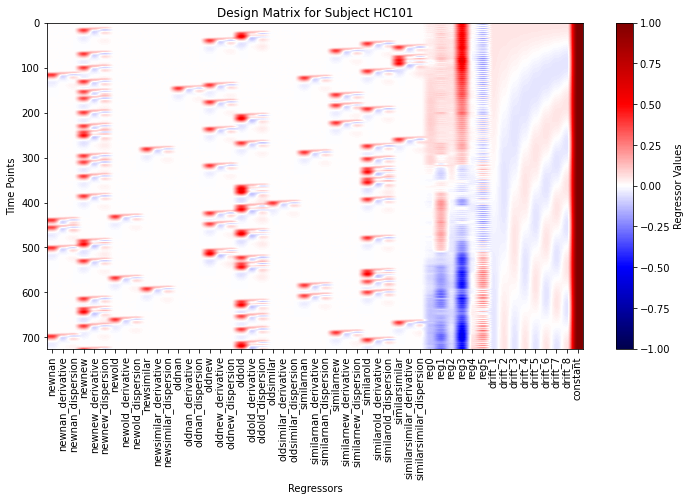

In [6]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 1.1 Plot contrasts to surfaces 

In [7]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_patternsep2=list(contrasts.keys())
contrasts_patternsep2 = np.ones((np.sum(shp), 2, len(subs), len(contrastnames_patternsep2))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrastnames_patternsep2):                 
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-MST2_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_patternsep2[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrastname_patternsep2}')

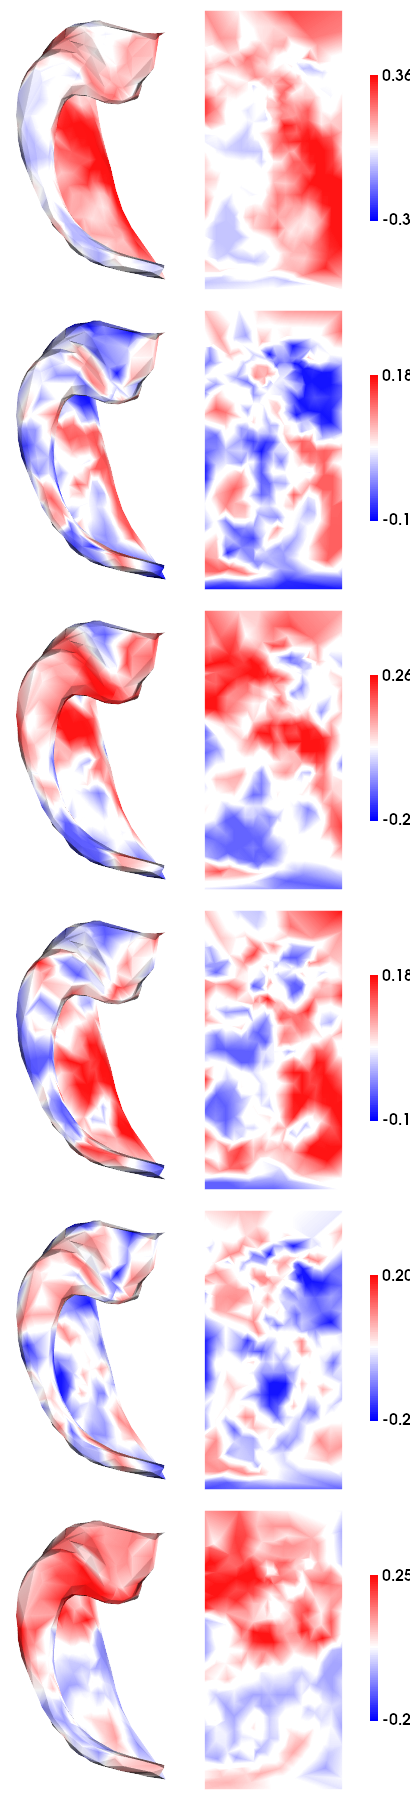

In [12]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

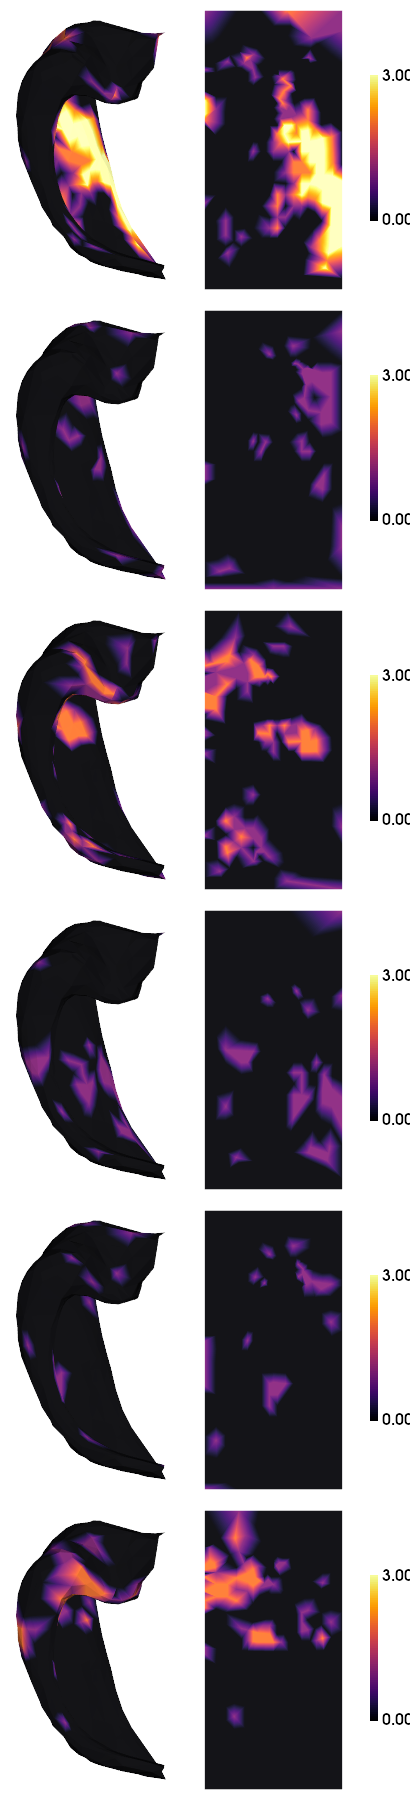

In [255]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_patternsep2.reshape((np.sum(shp),2*len(subs),len(contrastnames_patternsep2))),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [ ]:
#save the average maps
# Select the corrected contrasts only 
selected_contrastnames = contrastnames_patternsep2[-3:]
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for contrastname_patternsep2 in selected_contrastnames:
            contrast_idx = contrastnames_patternsep2.index(contrastname_patternsep2)
            cdat = np.nanmean(contrasts_patternsep2[ind[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-MST2_average-82_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_patternsep2}.shape.gii')

## compare to previously mapped features

In [103]:
my_shelf.close()

In [109]:
filename='../checkpoints/DimReduct.out'
my_shelf = shelve.open(filename)
cdata=my_shelf['cdata']
features=my_shelf['features']
subfieldsmaxcorr=my_shelf['subfieldsmaxcorr']
axiscorr=my_shelf['axiscorr']
subfields_permuted=my_shelf['subfields_permuted']
feature_n=my_shelf['feature_n']
AP=my_shelf['AP']
my_shelf.close()

In [100]:
taskMaps = np.nanmean(contrasts_patternsep2,axis=(1,2))[:,[0,2]]
a,_,_ = utils.density_interp('2mm','0p5mm',taskMaps[:,0], label='hipp')
b,_,_ = utils.density_interp('2mm','0p5mm',taskMaps[:,1], label='hipp')
taskMaps = np.vstack((a,b)).T

p = np.ones((taskMaps.shape[1],len(features)))
R = np.ones((taskMaps.shape[1],len(features)))
for i in range(taskMaps.shape[1]):
    for j in range(len(features)):
        _,_,p[i,j],R[i,j] = spin_test.spin_test(taskMaps[:,i],cdata[:,j], 10000, space='orig')

In [46]:
for f in range(2):
    order = np.argsort(np.abs(R[f,:]))[::-1]
    for t in range(3):
        print(f'R value {R[f,order[t]]}  Feature {features[order[t]]}  pvalue {p[f,order[t]]}')

R value 0.7258393149510467  Feature MRI-3T-rsfMRI-avgFCneocort  pvalue 0.0
R value 0.5862436688937758  Feature histology-thickness  pvalue 0.0002
R value -0.5823688481104942  Feature histology-curvature  pvalue 0.0002
R value -0.507260012375932  Feature iEEG-BandPower-beta  pvalue 0.004
R value -0.5005763561597286  Feature iEEG-BandPower-gamma  pvalue 0.0233
R value 0.4654862294582237  Feature MRI-3T-rsfMRI-IntTS  pvalue 0.0


In [120]:
APcorr = spearmanr(np.concatenate((taskMaps,AP.reshape([-1,1])),axis=1))[0][2:,:2]
APcorr = np.abs(APcorr)
Subfscorr = spearmanr(np.concatenate((taskMaps,subfields_permuted),axis=1))[0][2:,:2]
Subfscorr = np.nanmax(np.abs(Subfscorr),axis=0)

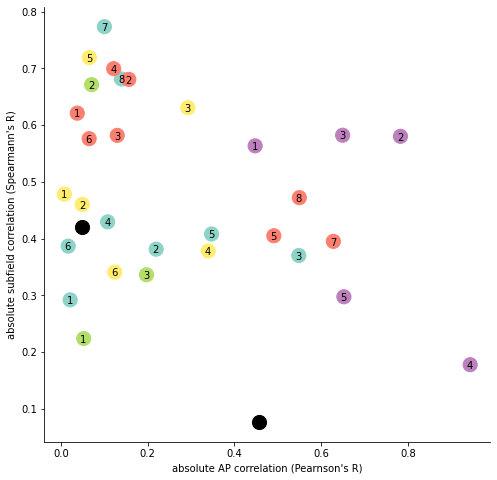

In [123]:
fig, ax = plt.subplots(figsize=(8,8))
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(axiscorr[0],subfieldsmaxcorr,c=colors,cmap='Set3',s=200)
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute AP correlation (Pearnson's R)")

for f,feature in enumerate(features):
    ax.annotate(str(int(feature_n[f])), (axiscorr[0,f]-.008, subfieldsmaxcorr[f]-.007))

ax.scatter(APcorr,Subfscorr,color='k',s=200)

## additional consistency checks

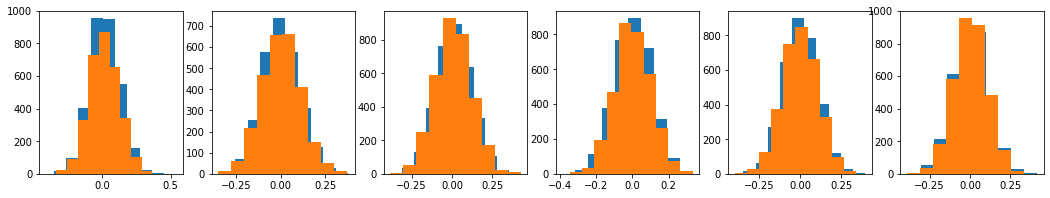

In [137]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_patternsep2)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_patternsep2), figsize=(3*len(contrastnames_patternsep2),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_patternsep2):
        cdat = contrasts_patternsep2[:,h,:,f].reshape((np.sum(shp),-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

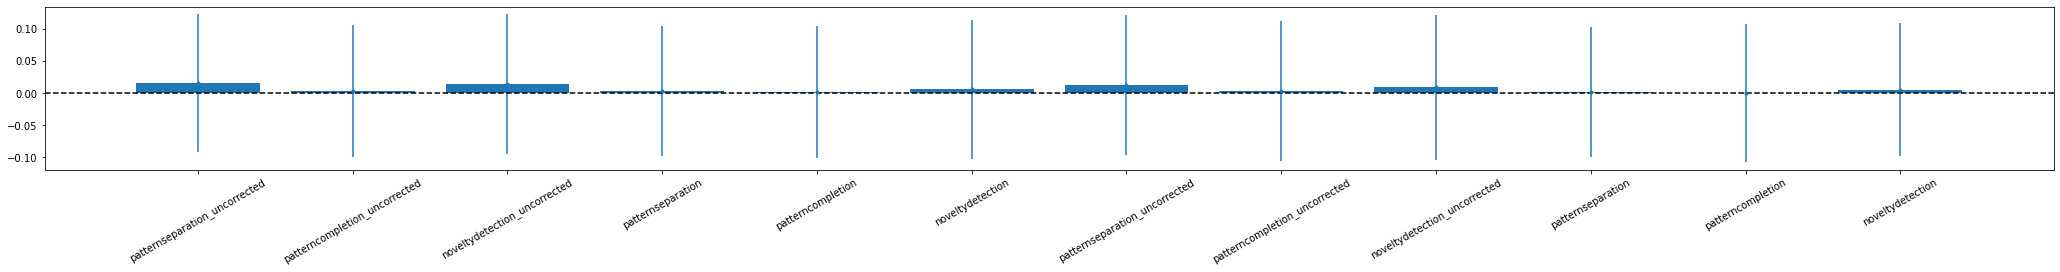

In [138]:
xnames = contrastnames_patternsep2 + contrastnames_patternsep2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')

In [89]:
#compute average across subjects for each contrasts and plot neocortical findings 
contrasts_patternsep2_neo = np.ones((200, 2, len(subs), len(contrastnames_patternsep2))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_patternsep2): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-MST2_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_patternsep2_neo[:,h, s, c] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrastname_patternsep2}')

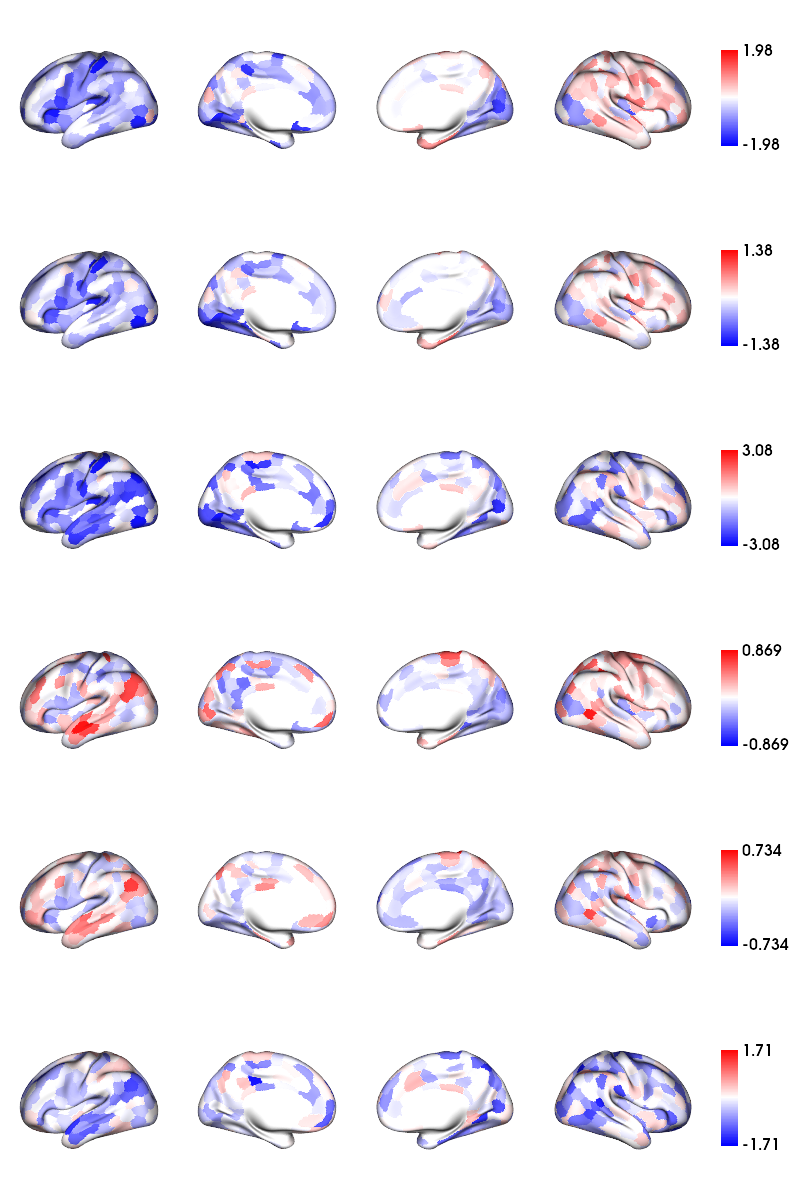

In [224]:
a=np.nanmean(contrasts_patternsep2_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

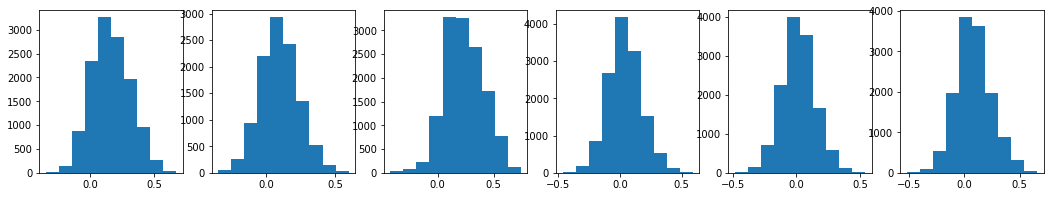

In [91]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_patternsep2)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_patternsep2), figsize=(3*len(contrastnames_patternsep2),3))
for f,feature in enumerate(contrastnames_patternsep2):
    cdat = contrasts_patternsep2_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

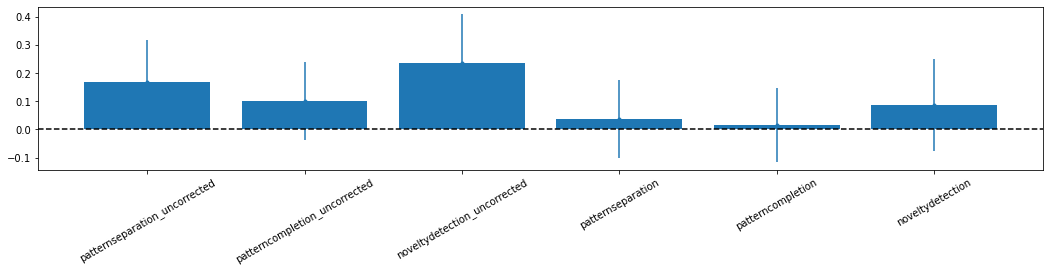

In [92]:
xnames = contrastnames_patternsep2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_patternsep2),3))
plt.bar(range(len(contrastnames_patternsep2)),mfcorr)
plt.errorbar(range(len(contrastnames_patternsep2)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_patternsep2)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

# 2.0 GLM fit for episodic retrieval

In [93]:
conditions = ['remembered', 'forgotten']
current_task='retrieval'
for sub in subs[-1:]:
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-retrieval_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    events = pd.read_table(events_file)
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','subject_response','prime','target']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    df['trial_type']=None
    df['trial_type'] = df.apply(lambda row: 'remembered' if row['target'] == row['subject_response'] else 'forgotten', axis=1)

    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'retrieval_uncorrected': (
        basic_contrasts['remembered']
        + basic_contrasts['remembered_derivative']
        + basic_contrasts['remembered_dispersion']),
    'retrieval_corrected': (
        basic_contrasts['remembered']
        - basic_contrasts['forgotten']
        + basic_contrasts['remembered_derivative']
        - basic_contrasts['forgotten_derivative']
        + basic_contrasts['remembered_dispersion']
        + basic_contrasts['forgotten_dispersion'])}
    
    
    ### Load the hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries and downsample to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-retrieval_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_retrieval_smooth-1mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_retrieval_smooth-1mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array, design_matrix.values)

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            #create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)


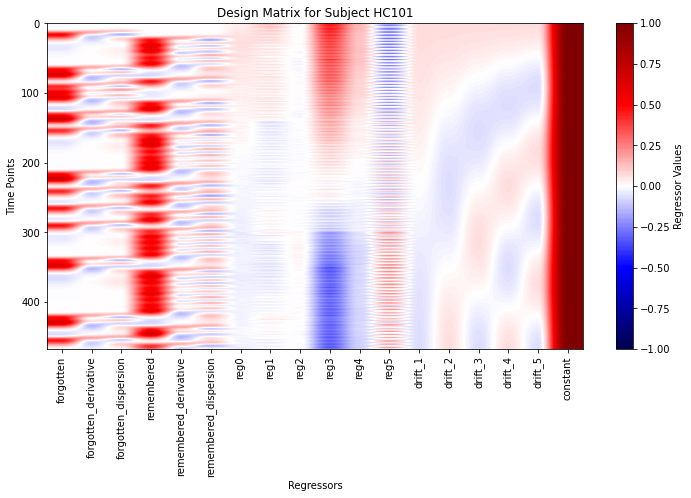

In [94]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 2.1 Plot to surfaces

In [96]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_epiretrieve=list(contrasts.keys())
contrasts_retrieval = np.ones((np.sum(shp), 2, len(subs), len(contrastnames_epiretrieve))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrastnames_epiretrieve):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-retrieval_contrast-{contrast_name}.shape.gii'
                try:                                                                           
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_retrieval[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrastname_epiretrieve}')

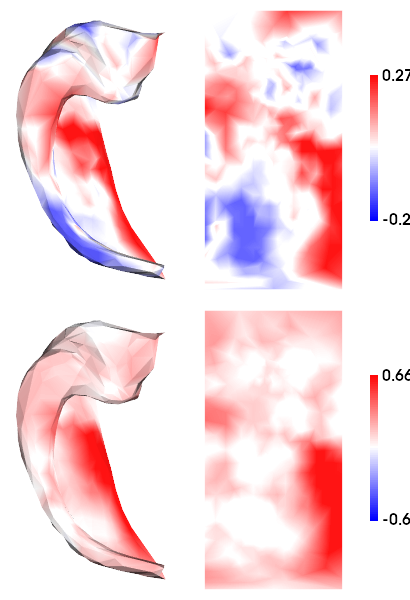

In [247]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_retrieval,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

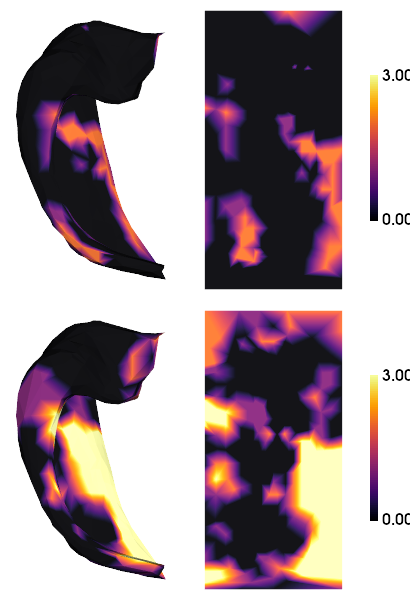

In [256]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_retrieval.reshape((np.sum(shp),2*len(subs),len(contrastnames_epiretrieve))),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [ ]:
#save the average maps
# Select the corrected contrasts only 
selected_contrastnames = contrastnames_epiretrieve[-1:]
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for contrastname_epiretrieve in selected_contrastnames:
            contrast_idx = contrastnames_epiretrieve.index(contrastname_epiretrieve)
            cdat = np.nanmean(contrasts_retrieval[ind[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiretrieve_average-82_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiretrieve}.shape.gii')

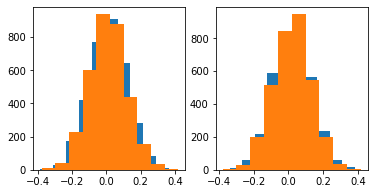

In [139]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_epiretrieve)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiretrieve), figsize=(3*len(contrastnames_epiretrieve),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_epiretrieve):
        cdat = contrasts_retrieval[:,h,:,f].reshape((np.sum(shp),-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

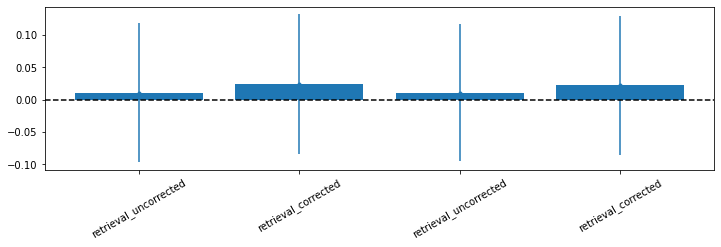

In [140]:
xnames = contrastnames_epiretrieve + contrastnames_epiretrieve

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

In [39]:
#compute average across subjects for each contrasts and plot neocortical findings 
contrasts_retrieval_neo = np.ones((200, 2, len(subs), len(contrastnames_epiretrieve))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_epiretrieve): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-retrieval_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_retrieval_neo[:,h, s, c] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrastname_epiretrieve}')

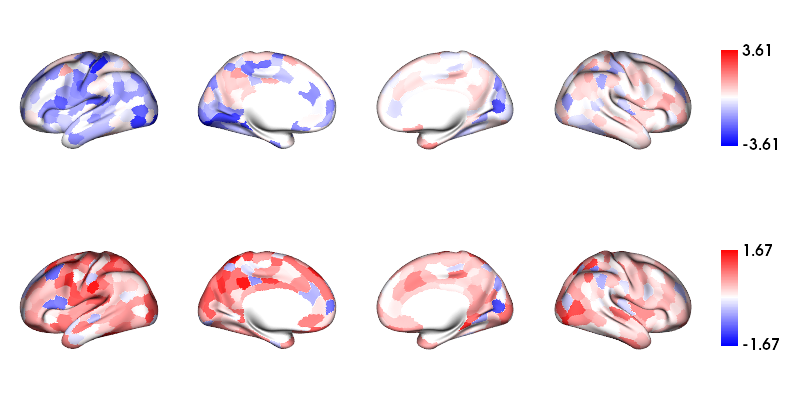

In [226]:
a=np.nanmean(contrasts_retrieval_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

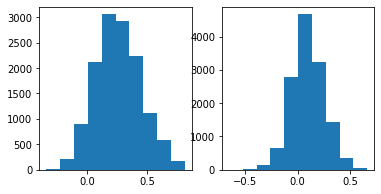

In [101]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_epiretrieve)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiretrieve), figsize=(3*len(contrastnames_epiretrieve),3))
for f,feature in enumerate(contrastnames_epiretrieve):
    cdat = contrasts_retrieval_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

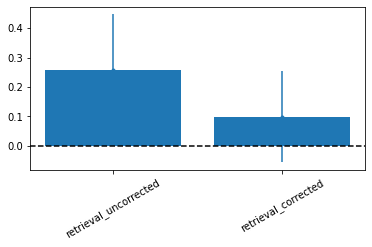

In [102]:
xnames = contrastnames_epiretrieve

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_epiretrieve),3))
plt.bar(range(len(contrastnames_epiretrieve)),mfcorr)
plt.errorbar(range(len(contrastnames_epiretrieve)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_epiretrieve)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

# 3. GLM fit for episodic encoding -subsequent memory 

In [104]:
conditions = ['correct', 'incorrect']
current_task='encoding'
for sub in subs[-1:]:
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-encoding_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load encoding file
    encoding_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-encoding_events.tsv'
    df_encode = pd.read_table(encoding_file)
    df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_duration','stim_1','stim_2']]
    df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_duration': 'duration'}, inplace=True)
    # Load retrieval file
    retrieval_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    df_retrieve = pd.read_table(retrieval_file)
    df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'event_3_onset','subject_response']]
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress'}, inplace=True)
    df_retrieve['trial_type']=None
    df_retrieve['trial_type'] = df_retrieve.apply(lambda row: 'correct' if row['target'] == row['subject_response'] else 'incorrect', axis=1)


    new_df = pd.DataFrame(columns=['onset','duration','prime','target','trial_type'])
    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    i=0
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df.loc[i] = [row_encode['onset'],
                                 row_encode['duration'],
                                 matched_row['prime'],
                                 matched_row['target'],
                                 matched_row['trial_type']]
                i+=1

                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    design_matrix = make_first_level_design_matrix(frame_times,
                                      events=new_df,
                                      hrf_model='spm + derivative + dispersion',
                                      add_regs=motion_reg)
    for condition in conditions:
        if condition not in design_matrix.columns:
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}           

    ### Load the hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-encoding_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_encoding_smooth-1mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_encoding_smooth-1mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array, design_matrix.values)

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            #create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)

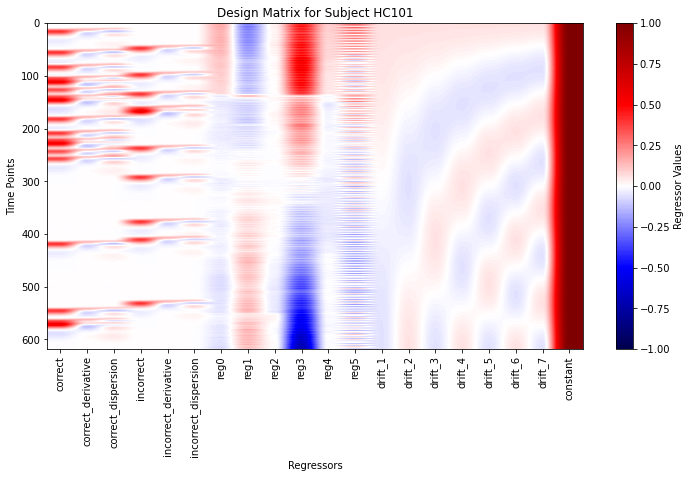

In [105]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 3.1 Plot to surfaces 

In [107]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_epiencode=list(contrasts.keys())
contrasts_epiencode = np.ones((np.sum(shp), 2, len(subs), len(contrastnames_epiencode))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrastname_epiencode in enumerate(contrastnames_epiencode):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-encoding_contrast-{contrastname_epiencode}.shape.gii'
                try:                                                                           
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiencode[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrastname_epiencode}')

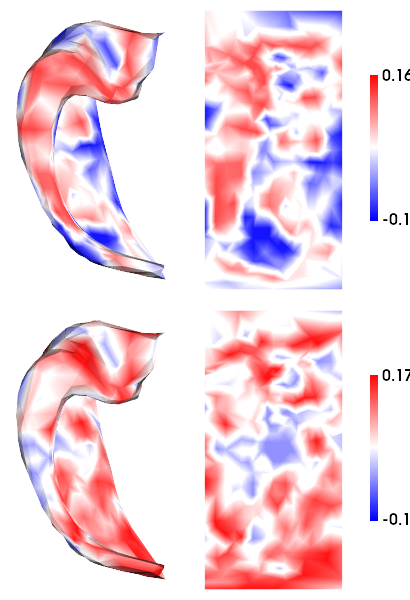

In [249]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

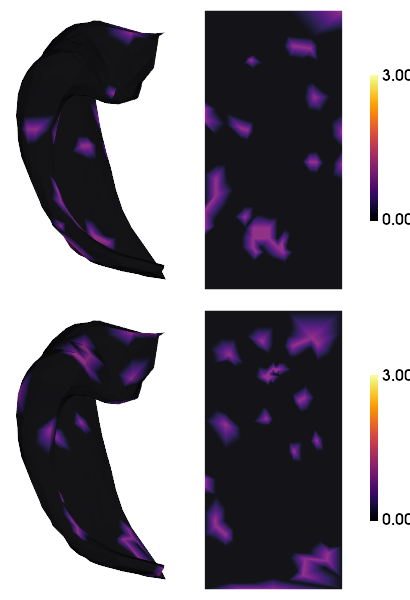

In [257]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_epiencode.reshape((np.sum(shp),2*len(subs),len(contrastnames_epiencode))),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [111]:
#save the average maps
# Select the corrected contrasts only 
selected_contrastnames = contrastnames_epiencode[-1:]
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for contrastname_epiencode in selected_contrastnames:
            contrast_idx = contrastnames_epiencode.index(contrastname_epiencode)
            cdat = np.nanmean(contrasts_epiencode[ind[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiencode_average-82_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiencode}.shape.gii')

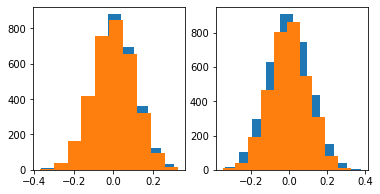

In [142]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_epiencode)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiencode), figsize=(3*len(contrastnames_epiencode),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_epiencode):
        cdat = contrasts_epiencode[:,h,:,f].reshape((np.sum(shp),-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

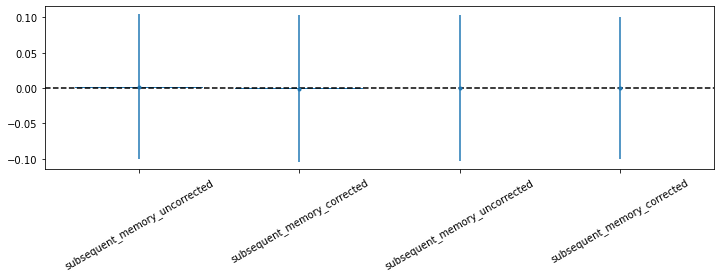

In [143]:
xnames = contrastnames_epiencode + contrastnames_epiencode

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

In [114]:
#compute average across subjects for each contrasts and plot neocortical findings 
contrasts_epiencode_neo = np.ones((200, 2, len(subs), len(contrastnames_epiencode))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_epiencode): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-encoding_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_epiencode_neo[:,h, s, c] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrastname_epiencode}')

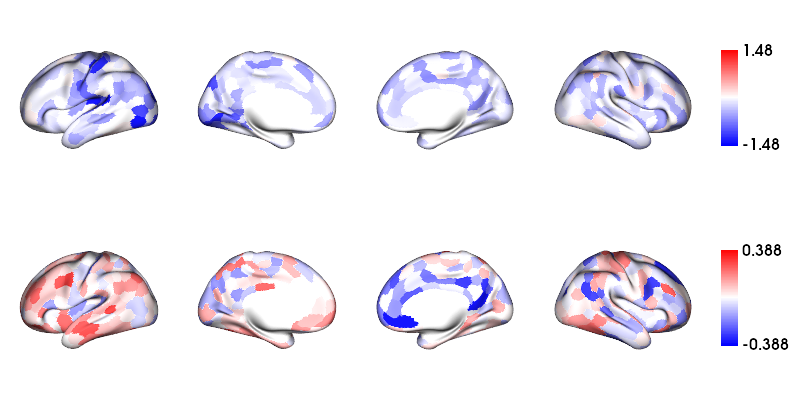

In [228]:
a=np.nanmean(contrasts_epiencode_neo,axis=2)
reshaped_a = a.reshape(a.shape[0]* a.shape[1] , a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[1]):
    mapped = map_to_labels(reshaped_a[:, i], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, cmap='bwr', color_range='sym', embed_nb=True, nan_color=(1, 1, 1, 1))

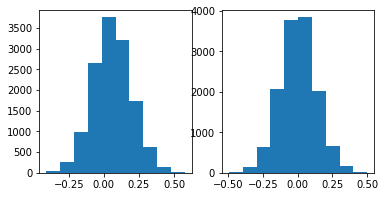

In [116]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_epiencode)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiencode), figsize=(3*len(contrastnames_epiencode),3))
for f,feature in enumerate(contrastnames_epiencode):
    cdat = contrasts_epiencode_neo[:,:,:,f].reshape((200,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

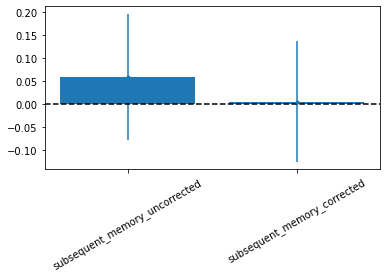

In [117]:
xnames = contrastnames_epiencode

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_epiencode),3))
plt.bar(range(len(contrastnames_epiencode)),mfcorr)
plt.errorbar(range(len(contrastnames_epiencode)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_epiencode)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

In [134]:
# save everything
import shelve
filename='../checkpoints/MRI-3T-taskfMRI.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: c69_inf_lh
ERROR shelving: c69_inf_rh
ERROR shelving: cmc
ERROR shelving: csv
ERROR shelving: exit
ERROR shelving: get_ipython
ERROR shelving: glob
ERROR shelving: my_shelf
ERROR shelving: nib
ERROR shelving: nilearn
ERROR shelving: np
ERROR shelving: os
ERROR shelving: pd
ERROR shelving: plotting
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: shelve
ERROR shelving: surface
ERROR shelving: sys
ERROR shelving: utils
ERROR shelving: warnings
